In [122]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from PIL import Image
from wordcloud import WordCloud
from google.cloud import language_v1

import io
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "lustrous-center-305403-9cd548f48b67.json"

# 1. Data Cleaning

In [2]:
# read data
data_test = pd.read_csv('religious_text_test.csv')
data_train = pd.read_csv('religious_text_train.csv')

In [19]:
# fill missing values
data_train[:] = data_train.fillna(0)
data_test[:] = data_test.fillna(0)

# rename the unnamed column to Chapters, '# foolishness' to just foolishness
data_train.rename(columns = {'Unnamed: 0' : 'Chapters'}, inplace = True)
data_test.rename(columns = {'# foolishness' : 'foolishness'}, inplace = True)

# make sure everything is an integer
data_test = data_test.applymap(int).astype(int)
data_train.iloc[:, 1:] = data_train.iloc[:, 1:].applymap(int).astype(int)

In [4]:
# Data validation stuff, more cleaning

all(data_train.iloc[:,1:].dtypes == 'int64') # True (All entries are integers)
all(data_test.dtypes == 'int64') # True (All entries are integers)

all(list(map(lambda a: ' ' not in a, data_train.iloc[:,1:].columns))) # Each column is one word
all(list(map(lambda a: ' ' not in a, data_test.columns))) # Each column is one word

True

# 2. Data Analysis

In [6]:
# Data to work with 

# Extraaaaaa way of getting the books lmao, dont do this
books = [i[0] for i in list(map(lambda a: a.split('_'), data_train['Chapters'].unique())) if i[1] == 'Ch1']

# dataframes segregated by chapters
book_list = [data_train[[j in i for i in data_train['Chapters']]] for j in books]

# top 20 words for each book in a list containing 8 series
top_20_books = [j.sort_values(ascending = False) for j in [i.iloc[:,1:].sum() for i in book_list]]

# total words in each book
total_words_book = dict(zip(books, [i.sum() for i in top_20_books]))

# total words in each chapter of each book (dictionary)
total_words_chapter = dict(zip(books,[pd.Series(data=i.iloc[:,1:].sum(axis=1).tolist(), index=i.iloc[:,0]) for i in book_list]))

# Top 20 words for all books
all_20 = data_train.iloc[:,1:].sum().sort_values(ascending = False)

# total words in the dataframe 
total_words = all_20.sum()

# proportion of words in the top 20 over total words in each book 
prop_20_book = dict(zip(books,[top_20_books[i][:20].sum() / [j.sum() for j in top_20_books][i] for i in range(8)]))

In [131]:
data_train.iloc[1]

Chapters       Buddhism_Ch2
foolishness               0
hath                      0
wholesome                 0
takest                    0
                   ...     
visual                    0
thoughts                  0
illumines                 0
attire                    0
explains                  0
Name: 1, Length: 8266, dtype: object

In [7]:
# Word cloud visualizations (ready for graphing)

mask = np.array(Image.open("book.png"))

# for all books in total
desc = all_20.index.tolist(); counts = all_20.tolist()
wordcloud_20 = WordCloud(mask = mask, max_words = len(all_20)).generate_from_frequencies(dict(zip(desc,counts))) # stored here

# for each book (in a list)
word_cloud_each = [] # all in this list
for i in top_20_books:
    desc = i[:20].index.tolist(); counts = i[:20].tolist()
    word_cloud_each.append(WordCloud(max_words = 20).generate_from_frequencies(dict(zip(desc,counts))))

In [10]:
# This code basically takes all scores calculated from the sentiment analysis text file,
# in order to help with sentiment score calculations 

sentiments = open('sentiment_analysis.txt', 'r')
scores = [float(line.split(' ')[3].strip()) for line in sentiments.readlines() if 'score' in line and 'Document' in line][1:]
sentiments.seek(0)
magnitude = [float(line.split(' ')[3].strip()) for line in sentiments.readlines() if 'magnitude' in line and 'Document' in line][1:]
sentiments.seek(0)
keys = [line.strip() for line in sentiments.readlines() if ' ' not in line and line.rstrip()]
scores_dict = dict(zip(keys,scores))
magnitude_dict = dict(zip(keys,magnitude))

# function to calculate sentiment scores
book_scores = list(map((lambda j: sum([scores_dict[k] * j[i] for i,k in enumerate(j.index.tolist())]) / sum(j.tolist())), top_20_books))
magnitude_scores = list(map((lambda j: sum([magnitude_dict[k] * j[i] for i,k in enumerate(j.index.tolist())]) / sum(j.tolist())), top_20_books))
top_20_scores = list(map((lambda j: sum([scores_dict[k] * j[:20][i] for i,k in enumerate(j[:20].index.tolist())]) / sum(j[:20].tolist())), top_20_books))
top_20_magnitude = list(map((lambda j: sum([magnitude_dict[k] * j[:20][i] for i,k in enumerate(j[:20].index.tolist())]) / sum(j[:20].tolist())), top_20_books))

# formatting the scores for graphing/visualization
scores_20 = dict(zip(books,list(top_20_scores)))
magnitude_20 = dict(zip(books,list(top_20_magnitude)))
book_scores_dict = dict(zip(books,list(book_scores)))
book_magnitude_dict = dict(zip(books,list(magnitude_scores)))

In [11]:
#Creating a deep copy of total_words
total_words_chapter_copy = {key: value[:] for key, value in total_words_chapter.items()}

#Deleting Chapter 27 From Buddhism
total_words_chapter_copy["Buddhism"].pop('Buddhism_Ch37')

1194

# 3. Visualizations 

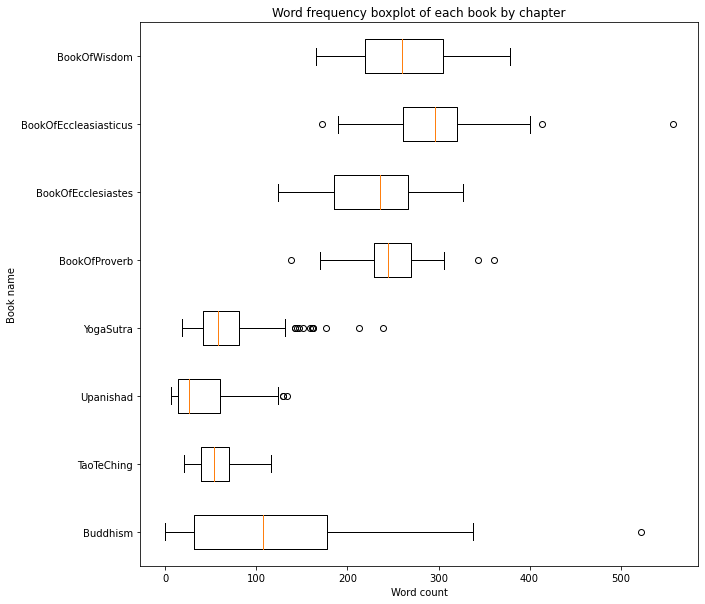

In [97]:
#BoxPlot
plt.rcParams['figure.figsize'] = (10, 10)
chapters_dict = {}
for book in total_words_chapter_copy.keys():
    chapters = [key for key in total_words_chapter_copy[book].keys()]
    chapters_count = [total_words_chapter_copy[book][key] for key in total_words_chapter_copy[book].keys()]
    chapters_dict[book] = chapters_count

fig, ax = plt.subplots()
ax.boxplot(chapters_dict.values(), vert = False)
ax.set_yticklabels(chapters_dict.keys())
ax.set_title("Word frequency boxplot of each book by chapter")
ax.set_ylabel("Book name"); ax.set_xlabel("Word count")
plt.show()

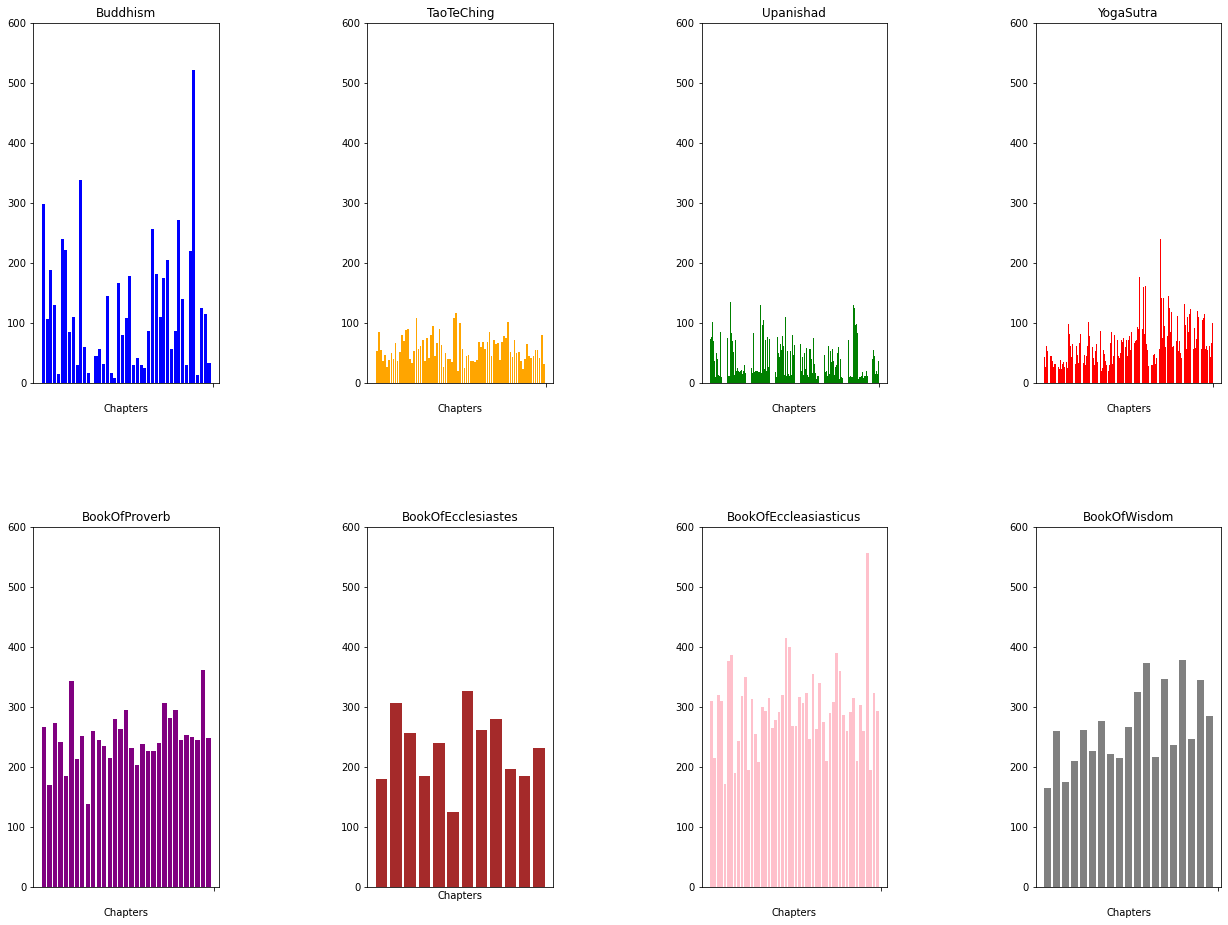

In [87]:
figure, axes = plt.subplots(nrows=2, ncols=4)
plt.title("Words Per Chapter")
colors = ['','blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
index = 1
for book in total_words_chapter_copy.keys():
    chapters = [key for key in total_words_chapter_copy[book].keys()]
    chapters_count = [total_words_chapter_copy[book][key] for key in total_words_chapter_copy[book].keys()]
    
    plt.subplot(2, 4, index) # row 1, col 2 index 1
    plt.bar(chapters, chapters_count, color = colors[index])
    plt.ylim(0, 600)
    plt.title(book)
    plt.xlabel("Chapters")
    plt.xticks(" ")
    index += 1

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.2, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.4)

plt.show()

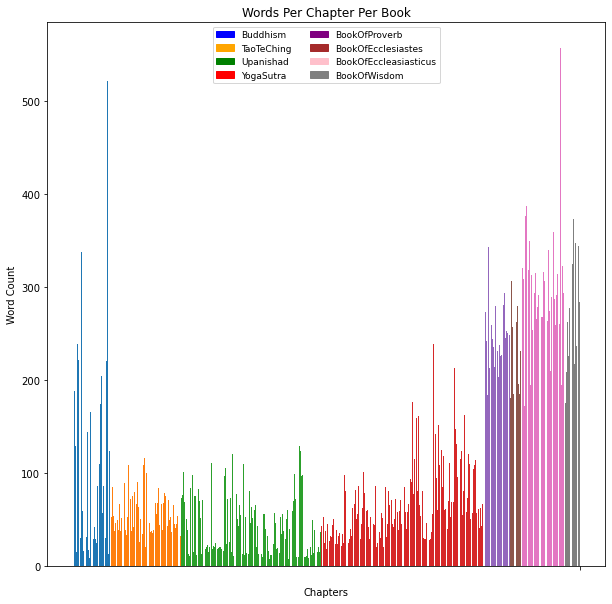

In [74]:
# Combined Barcharts
for book in total_words_chapter_copy.keys():
    chapters = [key for key in total_words_chapter_copy[book].keys()]
    chapters_count = [total_words_chapter_copy[book][key] for key in total_words_chapter_copy[book].keys()]
    plt.bar(chapters, chapters_count)

plt.xlabel("Chapters")
plt.ylabel("Word Count")
plt.xticks(" ")
plt.title("Words Per Chapter Per Book")

colors = {'Buddhism':'blue', 'TaoTeChing':'orange', 'Upanishad':'green', 'YogaSutra':'red', 'BookOfProverb':'purple', 'BookOfEcclesiastes':'brown', 'BookOfEccleasiasticus':'pink', 'BookOfWisdom':'gray'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color = colors[label]) for label in labels]
plt.legend(handles, labels, fontsize = 9, ncol = 2)

plt.show()

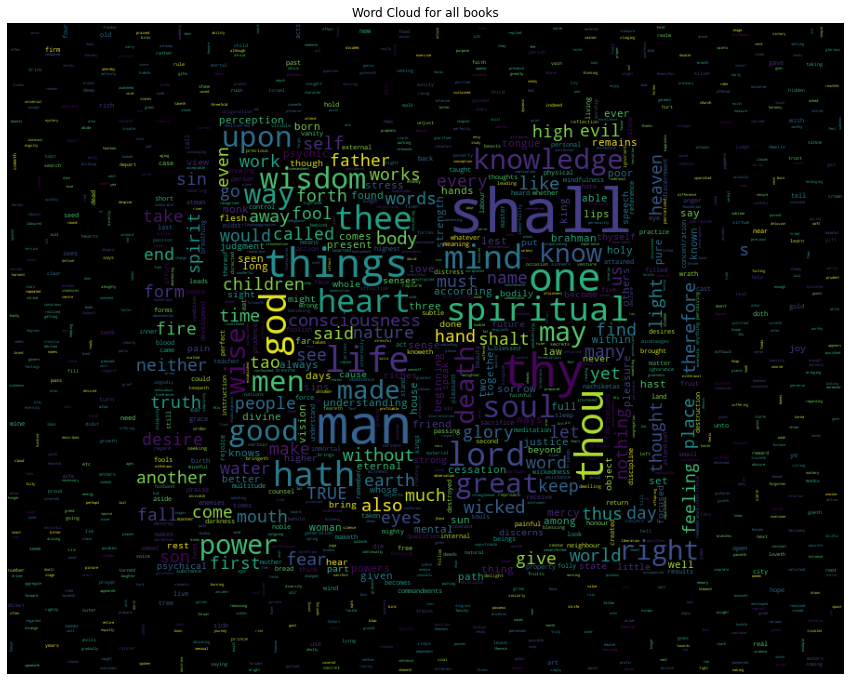

In [85]:
# word cloud visualizations
plt.rcParams['figure.figsize'] = (15, 15)
plt.imshow(wordcloud_20)
plt.axis('off')
plt.title('Word Cloud for all books')
plt.show()

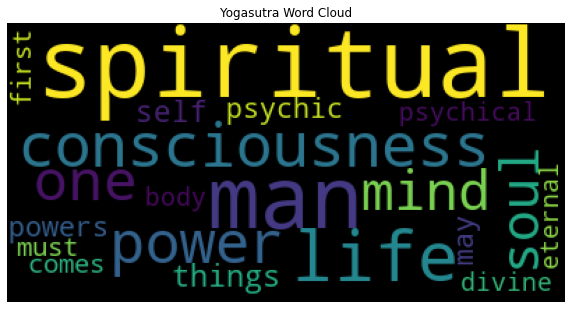

In [151]:
plt.rcParams['figure.figsize'] = (10,10)
  
plt.imshow(word_cloud_each[3]);
plt.axis('off');
plt.title('Yogasutra Word Cloud');

#plt.imshow(word_cloud_each[4]);
#plt.axis('off');
#plt.title('Book Of Proverb Word Cloud');

#plt.imshow(word_cloud_each[5])
#plt.axis('off');
#plt.title('Book Of Ecclesiastes Word Cloud');

#plt.imshow(word_cloud_each[6]);
#plt.axis('off');
#plt.title('Book Of Ecclesiasticus Word Cloud');

#plt.imshow(word_cloud_each[7])
#plt.axis('off');
#plt.title('Book Of Wisdom Word Cloud');
#plt.show()

#plt.imshow(word_cloud_each[0]);
#plt.axis('off');
#plt.title('Buddhism Word Cloud');


#plt.imshow(word_cloud_each[1]);
#plt.axis('off');
#plt.title('Tao Te Ching Word Cloud');


#plt.imshow(word_cloud_each[2])
#plt.axis('off');
#plt.title('Upanishad Word Cloud');

In [134]:
books

['Buddhism',
 'TaoTeChing',
 'Upanishad',
 'YogaSutra',
 'BookOfProverb',
 'BookOfEcclesiastes',
 'BookOfEccleasiasticus',
 'BookOfWisdom']

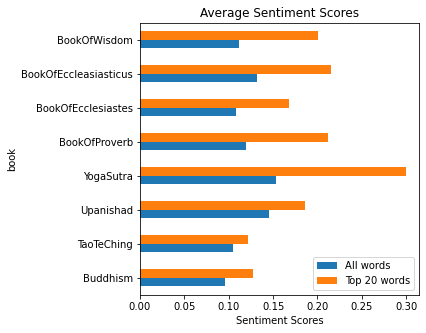

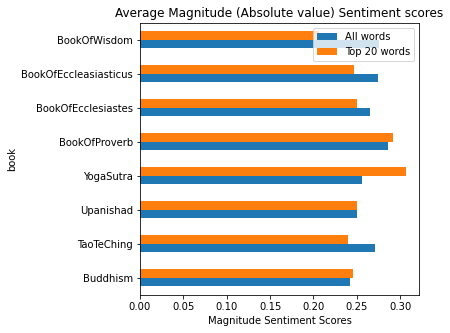

In [119]:
plt.rcParams['figure.figsize'] = (5,5)
book_names = books
scores_val = list(book_scores_dict.values())
scores_20_val = list(scores_20.values())
mags_val = list(book_magnitude_dict.values())
mags_20_val = list(magnitude_20.values())

scores_table = pd.DataFrame().assign(book = book_names, scores = scores_val)
mags_table = pd.DataFrame().assign(book = book_names, mags = mags_val)
scores_20_table = pd.DataFrame().assign(book = book_names, scores_20_val = scores_20_val)
mags_20_table = pd.DataFrame().assign(book = book_names, mags_20_val = mags_20_val)

scores_v_20 = scores_table.merge(scores_20_table, left_on = 'book', right_on = 'book').set_index('book')
mags_v_20 = mags_table.merge(mags_20_table, left_on = 'book', right_on = 'book').set_index('book')

score_plt = scores_v_20.plot.barh()
mag_plt = mags_v_20.plot.barh()
score_plt.set_title("Average Sentiment Scores"); score_plt.set_xlabel("Sentiment Scores")
mag_plt.set_title('Average Magnitude (Absolute value) Sentiment scores'); mag_plt.set_xlabel("Magnitude Sentiment Scores")

score_leg = score_plt.legend()
score_leg.get_texts()[0].set_text('All words'); score_leg.get_texts()[1].set_text('Top 20 words')
mag_leg = mag_plt.legend()
mag_leg.get_texts()[0].set_text('All words'); mag_leg.get_texts()[1].set_text('Top 20 words')
plt.show()

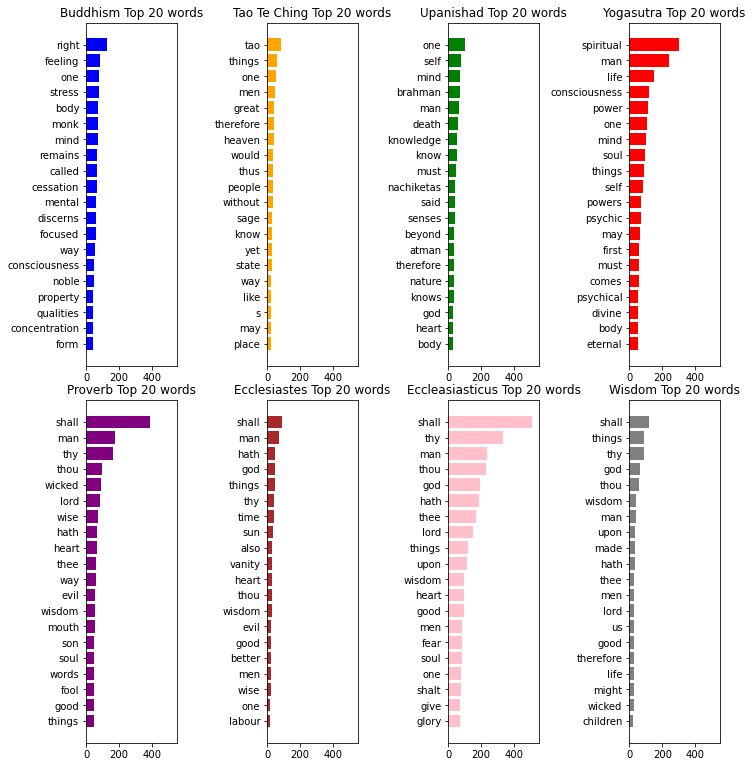

In [162]:
#first row of the graph

fig, axs = plt.subplots(2,4, figsize=(8,5))
colors = ['','blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
index = 1
for i in range(len(top_20_books)//2):
    counts = [top_20_books[i][j] for j in range(0,20)]
    counts_reverse = counts[::-1]
    top_20 = list(top_20_books[i][:20].keys())
    top_20_reversed = top_20[::-1]
    names = ['Buddhism', 'Tao Te Ching', 'Upanishad', 'Yogasutra']
    #plt.subplots(2, 4, index) # row 2, col 4, index
    axs[0,i].barh(top_20_reversed, counts_reverse, color = colors[index])
    axs[0,i].set_xlim([0, 550])
    axs[0,i].set_title(names[i] + ' Top 20 words')
    index += 1

#second row of the graph   
for i in range(len(top_20_books)//2, len(top_20_books)):
    counts = [top_20_books[i][j] for j in range(0,20)]
    counts_reverse = counts[::-1]
    top_20 = list(top_20_books[i][:20].keys())
    top_20_reversed = top_20[::-1]
    names_1 = ['Proverb', 'Ecclesiastes', 'Eccleasiasticus', 'Wisdom']
    #plt.subplots(2, 4, index) # row 2, col 4, index
    axs[1,i-4].barh(top_20_reversed, counts_reverse, color = colors[index])
    axs[1,i-4].set_xlim([0, 550])
    axs[1,i-4].set_title(names_1[i-4] + ' Top 20 words')
    index += 1
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.2, 
                    top=2.1, 
                    wspace=1.0, 
                    hspace=0.1)


                    
plt.show()

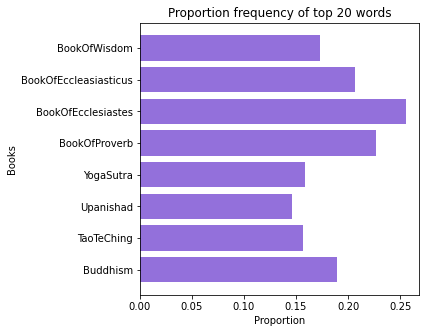

In [84]:
# Count of Top 20 Words vs Total Words
twenty_totals = []
for i in range(len(top_20_books)):
    top_20_total = sum([top_20_books[i][:20][j] for j in range(len(top_20_books[0][:20]))])
    twenty_totals.append(top_20_total)

all_totals = []
for book in total_words_book:
    all_totals.append(total_words_book[book])

proportions = []
for i in range(len(twenty_totals)):
    proportions.append(twenty_totals[i] / all_totals[i])
    
    plt.barh(books[i], proportions[i], color = "mediumpurple")
plt.title("Proportion frequency of top 20 words")
plt.xlabel('Proportion'); plt.ylabel('Books')
plt.show()